# Parte A

Levantar cluster en AWS con Hadoop y Pyspark
Nombre: cluster_ + la mátricula (número de estudiante) más chica

Acceso a JupyterHub
JupyterHub: https://master-public-dns-name:9443/
- u: `jovyan`
- p: `jupyter`

Librerías y sesión de Spark

In [1]:
# Importar librerías
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    year, to_date, countDistinct, 
    col, max as max_, row_number, 
    collect_list, array_contains, lag)
from pyspark.sql.window import Window
from pyspark.sql.types import StringType

BUCKET = "s3://proyecto-parcial-equipo-6/"

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1713996466426_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Carga el CSV en Spark

In [2]:
# Inicia una sesión Spark.
spark = SparkSession.builder.appName("parteA").getOrCreate()

# Lee desde S3.
df = spark.read.csv(BUCKET + "clean/", header=False, inferSchema=True, sep='|')

# Revisión de estructura de datos antes de tener los headers
# Muestra las primeras filas para asegurarte de que se ha cargado correctamente.
df.show(20)

# Muestra schema
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+----------------+--------------------+------------------+-----+----------+------------+--------------------+--------------------+--------------------+--------------+--------------+---------+-----------+
|                 _c0|                 _c1|             _c2|                 _c3|               _c4|  _c5|       _c6|         _c7|                 _c8|                 _c9|                _c10|          _c11|          _c12|     _c13|       _c14|
+--------------------+--------------------+----------------+--------------------+------------------+-----+----------+------------+--------------------+--------------------+--------------------+--------------+--------------+---------+-----------+
|             a.s.cor|frasco gotero 24 ...|             s/m|        medicamentos|      medicamentos|389.0|2023-01-02|mega soriana|supermercado / ti...|mega soriana sucu...|aguascalientes nt...|aguascalientes|aguascalientes|21.916001|-102.290779|
|              a

Adición de headers, 
Optimizar data types

In [3]:
# Renombrar las columnas del DataFrame.
df_with_headers = df.toDF("producto", "presentacion", "marca", "categoria", "catalogo", "precio", "fecha_registro", "cadena_comercial", "giro", "nombre_comercial", "direccion", "estado", "municipio", "latitud", "longitud")

# optimizar data type
df_with_headers = df_with_headers.withColumn("latitud", col("latitud").cast("float"))
df_with_headers = df_with_headers.withColumn("longitud", col("longitud").cast("float"))

# Muestra las primeras filas para asegurarte de que se han cargado correctamente con los nuevos encabezados.
df_with_headers.show(20)

# Muestra schema
df_with_headers.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+----------------+--------------------+------------------+------+--------------+----------------+--------------------+--------------------+--------------------+--------------+--------------+-------+----------+
|            producto|        presentacion|           marca|           categoria|          catalogo|precio|fecha_registro|cadena_comercial|                giro|    nombre_comercial|           direccion|        estado|     municipio|latitud|  longitud|
+--------------------+--------------------+----------------+--------------------+------------------+------+--------------+----------------+--------------------+--------------------+--------------------+--------------+--------------+-------+----------+
|             a.s.cor|frasco gotero 24 ...|             s/m|        medicamentos|      medicamentos| 389.0|    2023-01-02|    mega soriana|supermercado / ti...|mega soriana sucu...|aguascalientes nt...|aguascalientes|aguascalientes| 21.916|-102

Guarda el CSV como parquet en S3, particionalo por catalogo. (Utiliza todos los trucos que consideres).

In [5]:
# Guarda el CSV como parquet en S3, particionalo por catalogo
df_with_headers.write.mode("overwrite").partitionBy("catalogo").parquet(BUCKET + "output/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Carga el parquet en Spark

In [4]:
# Carga del parquet en Spark
parquet_df = spark.read.parquet(BUCKET + "output/")

# Muestra las primeras filas para verificar.
parquet_df.show(20)

# Muestra schema
parquet_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----------------+--------------------+------+--------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------+---------+-----------+-----------+
|            producto|        presentacion|            marca|           categoria|precio|fecha_registro|    cadena_comercial|                giro|    nombre_comercial|           direccion|        estado|     municipio|  latitud|   longitud|   catalogo|
+--------------------+--------------------+-----------------+--------------------+------+--------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------+---------+-----------+-----------+
|            sterimar|caja con envase d...|              s/m|        medicamentos| 149.0|    2019-05-06|            chedraui|supermercado / ti...|chedraui sucursal...|dr. rafael lucio ...|      veracruz|        xalapa| 19.52893| -96.921875|a

¿Cuántos catálogos diferentes tenemos?

In [9]:
catalog_count_by_year = (parquet_df
    .groupBy(year("fecha_registro").alias("año"))  # Extrae el año y agrupa por este
    .agg(countDistinct("catalogo").alias("distinct_catalogs"))  # Cuenta los catálogos únicos
)

# Muestra el resultado.
catalog_count_by_year.show()

# Guarda la salida en el bucket de S3.
catalog_count_by_year.write.mode("overwrite").parquet(BUCKET + "preguntas/diff_catalogs/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-----------------+
| a?o|distinct_catalogs|
+----+-----------------+
|2018|               10|
|2019|               11|
|2020|               10|
|2021|               10|
|2022|               11|
|2023|               11|
|2024|               10|
+----+-----------------+

¿Cuáles son los 20 catálogos con más observaciones? Guarda la salida de este query en tu bucket de S3, lo necesitaremos más adelante.

In [11]:
# Encuentra los 20 catálogos con más observaciones.
top_catalogs = parquet_df.groupBy("catalogo").count().orderBy(col("count").desc()).limit(20)

# Muestra el resultado.
top_catalogs.show()

# Guarda la salida en el bucket de S3.
top_catalogs.write.mode("overwrite").parquet(BUCKET + "preguntas/top_catalogs/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------+
|           catalogo|   count|
+-------------------+--------+
|            basicos|46967421|
|       medicamentos|19223453|
|  electrodomesticos| 7175538|
| frutas y legumbres| 5041732|
|   utiles escolares| 2936010|
|           mercados| 2238684|
|           juguetes| 1432183|
|              pacic| 1079162|
|pescados y mariscos|  569632|
|           navideos|  236543|
|              tenis|   15768|
|        aeropuertos|     581|
+-------------------+--------+

¿Tenemos datos de todos los estados del país? De no ser así, ¿cuáles faltan?

In [12]:
# Lista todos los estados únicos presentes en el DataFrame.
unique_states = parquet_df.select("estado").distinct()

# Muestra los estados únicos.
unique_states.show()

# Opcional: Guarda la salida en el bucket de S3.
unique_states.write.mode("overwrite").csv(BUCKET + "preguntas/unique_states/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+
|         estado|
+---------------+
|ciudad de mxico|
|     tamaulipas|
|      zacatecas|
|       campeche|
|         yucatn|
|       veracruz|
|        morelos|
|     guanajuato|
|         sonora|
|       tlaxcala|
|        nayarit|
|        sinaloa|
|         oaxaca|
|       guerrero|
|   quintana roo|
|       quertaro|
| san luis potos|
|         puebla|
|        durango|
|estado de mxico|
+---------------+
only showing top 20 rows

In [13]:
# all_states es una lista de todos los estados posibles del país.
all_states = ['ciudad de mxico','tamaulipas','zacatecas','campeche','yucatn','veracruz','morelos',
              'guanajuato','sonora','tlaxcala','nayarit','sinaloa','oaxaca','guerrero',
              'quintana roo','quertaro','san luis potos','puebla','durango','estado de mxico',
              'jalisco','aguascalientes','coahuila de zaragoza','baja california sur','colima',
              'nuevo len','tabasco','chihuahua','baja california','michoacn de ocampo','chiapas',
              'hidalgo']

# Crea un DataFrame para la lista completa de estados.
all_states_df = spark.createDataFrame([(state,) for state in all_states], ["estado"])

# Realiza un anti join para encontrar los estados que faltan.
missing_states = all_states_df.join(unique_states, "estado", "left_anti")

# Muestra los estados que faltan.
missing_states.show()

# Opcional: Guarda la salida en el bucket de S3.
missing_states.write.mode("overwrite").csv(BUCKET + "preguntas/missing_states/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+
|estado|
+------+
+------+

¿Cuántas observaciones tenemos por estado?

In [14]:
# Agrupa por estado y cuenta las observaciones
observations_per_state = parquet_df.groupBy("estado").count().orderBy(col("count").desc())

# Muestra los resultados
observations_per_state.show()

# Opcional: Guarda la salida en el bucket de S3.
observations_per_state.write.mode("overwrite").csv(BUCKET + "preguntas/observations_per_state/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------+
|              estado|   count|
+--------------------+--------+
|     ciudad de mxico|17968798|
|     estado de mxico|12537548|
|             jalisco| 4182990|
|           nuevo len| 3358320|
|          guanajuato| 3330005|
|        quintana roo| 2821004|
|            veracruz| 2661838|
|            quertaro| 2534860|
|             tabasco| 2471506|
|           zacatecas| 2380067|
|              puebla| 2345346|
|              yucatn| 2331663|
|          tamaulipas| 1896217|
|              sonora| 1887619|
|            tlaxcala| 1810148|
|           chihuahua| 1798478|
|            campeche| 1765074|
|      san luis potos| 1718257|
|      aguascalientes| 1668545|
|coahuila de zaragoza| 1616519|
+--------------------+--------+
only showing top 20 rows

De cada estado obten: el número de catalogos diferentes por año, ¿ha aumentado el número de catálogos con el tiempo?

In [17]:
# Define una ventana particionada por estado y ordenada por año para análisis temporal.
windowSpec = Window.partitionBy("estado").orderBy("year")

# Preparar el DataFrame y calcular el número de catálogos distintos por estado y año, y el cambio año a año.
catalogs_per_state_year = (
    parquet_df
    # Asegurarse de que 'fecha_registro' está en formato de fecha correcto.
    .withColumn("fecha_registro", to_date("fecha_registro", "yyyy-MM-dd"))
    # Extraer el año y agrupar por este y por estado.
    .groupBy("estado", year("fecha_registro").alias("year"))
    .agg(countDistinct("catalogo").alias("num_catalogs"))
    # Calcular el número de catálogos del año anterior y el cambio respecto al año anterior.
    .withColumn("prev_year_catalogs", lag("num_catalogs", 1).over(windowSpec))
    .withColumn("change", col("num_catalogs") - col("prev_year_catalogs"))
    .select("estado", "year", "num_catalogs", "change")
    .orderBy("estado", "year")
)

# Muestra los resultados
catalogs_per_state_year.show()

# Opcional: Guarda la salida en el bucket de S3.
catalogs_per_state_year.write.mode("overwrite").csv(BUCKET + "preguntas/catalogs_per_state_year/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----+------------+------+
|             estado|year|num_catalogs|change|
+-------------------+----+------------+------+
|     aguascalientes|2018|           9|  NULL|
|     aguascalientes|2019|          11|     2|
|     aguascalientes|2020|           9|    -2|
|     aguascalientes|2021|          10|     1|
|     aguascalientes|2022|          11|     1|
|     aguascalientes|2023|          11|     0|
|     aguascalientes|2024|           9|    -2|
|    baja california|2018|          10|  NULL|
|    baja california|2019|          10|     0|
|    baja california|2020|           9|    -1|
|    baja california|2021|           9|     0|
|    baja california|2022|          11|     2|
|    baja california|2023|          11|     0|
|    baja california|2024|          10|    -1|
|baja california sur|2018|           9|  NULL|
|baja california sur|2019|          10|     1|
|baja california sur|2020|           9|    -1|
|baja california sur|2021|          10|     1|
|baja califor

Utilizando Spark contesta las siguientes preguntas a partir del catálogo que le tocó a tu equipo. Recuerda trabajar en el archivo con los datos particionados de otra manera tus queries van a tardar mucho.

¿Cuańtas marcas diferentes tiene tu categoría?

In [5]:
# Filtra por catalogo asignado
filtered_df = parquet_df.filter(col("catalogo") == "basicos")

# Selecciona la columna 'marca', encuentra valores únicos, y cuenta
unique_brands_count = filtered_df.select("marca").distinct().count()

print(f"Numero de marcas unicas en la catalogo: 'Basicos': {unique_brands_count}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Numero de marcas unicas en la catalogo: 'Basicos': 658

¿Cuál es la marca con mayor precio? ¿En qué estado?

In [20]:
# Encuentra la marca con el precio más alto y el estado correspondiente
max_price_info = filtered_df.orderBy(col("precio").desc()).select("marca", "precio", "estado").first()

print(f"La marca con el precio más alto es {max_price_info['marca']} con un precio de {max_price_info['precio']} en el estado de {max_price_info['estado']}.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

La marca con el precio m?s alto es sin marca con un precio de 899.0 en el estado de tlaxcala.

¿Cuál es la marca con menor precio en CDMX? (en aquel entonces Distrito Federal)

In [23]:
# Filtra por estados que contengan la secuencia 'CIUDAD DE'
df_cdmx = filtered_df.filter(col("estado").contains("ciudad de"))

# Encuentra la marca con el precio más bajo y el estado correspondiente
min_price_info = df_cdmx.orderBy(col("precio").asc()).select("marca", "precio", "municipio").first()

print(f"La marca con el precio más bajo en Ciudad de México es {min_price_info['marca']} con un precio de {min_price_info['precio']}.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

La marca con el precio m?s bajo en Ciudad de M?xico es s/m con un precio de 1.0.

¿Cuál es la marca con mayores observaciones?

In [24]:
# Agrupa por la columna 'marca' y cuenta el número de observaciones para cada marca
brand_counts = filtered_df.groupBy("marca").count()

# Ordena los resultados por el conteo en orden descendente y toma la primera fila
most_observed_brand = brand_counts.orderBy(col("count").desc()).first()

# Verifica si hay resultados antes de acceder al resultado
if most_observed_brand:
    print(f"La marca con el mayor número de observaciones es {most_observed_brand['marca']}, con {most_observed_brand['count']} observaciones.")
else:
    print("No se encontraron registros en el dataset.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

La marca con el mayor n?mero de observaciones es s/m, con 2762155 observaciones.

¿Cuáles son el top 5 de marcas con mayor precio en cada estado? ¿Son diferentes?

In [6]:
# Definir una ventana ordenada por precio descendente dentro de cada estado
windowSpec = Window.partitionBy("estado").orderBy(col("precio").desc())

# Aplicar la ventana con un número de fila para identificar los 5 principales
state_brand_prices = filtered_df.withColumn("row_number", row_number().over(windowSpec)) \
    .filter(col("row_number") <= 5) \
    .select("estado", "marca", "precio", "row_number")

state_brand_prices.show()

# Para comparar las 5 listas principales en diferentes estados, las recopilamos e imprimimos agrupadas por estado.
top_brands_by_state = state_brand_prices.groupBy("estado") \
    .agg(collect_list("marca").alias("top_5_brands")) \
    .orderBy("estado")
top_brands_by_state.show(50, False)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------+------+----------+
|             estado|     marca|precio|row_number|
+-------------------+----------+------+----------+
|     aguascalientes|  saba cup| 609.0|         1|
|     aguascalientes|  saba cup| 609.0|         2|
|     aguascalientes|  saba cup| 609.0|         3|
|     aguascalientes|  saba cup| 609.0|         4|
|     aguascalientes|  saba cup| 609.0|         5|
|    baja california|       s/m| 659.9|         1|
|    baja california|       s/m| 659.9|         2|
|    baja california|       s/m| 659.9|         3|
|    baja california|       s/m| 659.9|         4|
|    baja california|       s/m| 659.9|         5|
|baja california sur|diva cup 2| 690.0|         1|
|baja california sur|diva cup 2| 690.0|         2|
|baja california sur|diva cup 2| 690.0|         3|
|baja california sur|diva cup 2| 690.0|         4|
|baja california sur|diva cup 2| 690.0|         5|
|           campeche|  saba cup| 580.0|         1|
|           campeche|  saba cup

¿Cuáles son el top 5 de marcas con menor precio en CDMX? (en aquel entonces Distrito Federal)

In [26]:
# Define una ventana ordenada por precio ascendente dentro de cada estado que contiene "CIUDAD DE".
windowSpec = Window.partitionBy("estado").orderBy(col("precio").asc())

# Aplica la especificación de ventana con un número de fila para identificar el top 5 de precios más bajos.
lowest_price_brands = filtered_df.withColumn("row_number", row_number().over(windowSpec)) \
    .filter(col("row_number") <= 5) \
    .select("estado", "marca", "precio", "row_number")

# Muestra las 5 marcas con los precios más bajos en los estados que contienen "CIUDAD DE".
lowest_price_brands.show()

# Para comparar las listas del top 5 entre diferentes "CIUDAD DE", las recopilamos y las mostramos agrupadas por estado.
top_brands_by_state_lowest = lowest_price_brands.groupBy("estado") \
    .agg(collect_list("marca").alias("top_5_lowest_brands")) \
    .orderBy("estado")
top_brands_by_state_lowest.show(50, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+------+----------+
|             estado|marca|precio|row_number|
+-------------------+-----+------+----------+
|     aguascalientes|  s/m|   1.0|         1|
|     aguascalientes|  s/m|   1.2|         2|
|     aguascalientes|  s/m|   1.2|         3|
|     aguascalientes|  s/m|   1.2|         4|
|     aguascalientes|  s/m|   1.2|         5|
|    baja california|  s/m|   1.5|         1|
|    baja california|  s/m|   1.5|         2|
|    baja california|  s/m|   1.5|         3|
|    baja california|  s/m|   1.5|         4|
|    baja california|  s/m|   1.5|         5|
|baja california sur|  s/m|  1.15|         1|
|baja california sur|  s/m|  1.15|         2|
|baja california sur|  s/m|  1.15|         3|
|baja california sur|  s/m|  1.15|         4|
|baja california sur|  s/m|   1.2|         5|
|           campeche|  s/m|   1.1|         1|
|           campeche|  s/m|   1.1|         2|
|           campeche|  s/m|   1.1|         3|
|           campeche|  s/m|   1.1|

¿Cuáles son el top 5 de marcas con mayores observaciones? ¿Se parecen a las de nivel por estado?

In [27]:
# Contar las ocurrencias de cada marca en todo el dataset
brand_occurrences = filtered_df.groupBy("marca").count()

# Ordenar las marcas por el número de observaciones en orden descendente y seleccionar el top 5
top_5_brands_observations = brand_occurrences.orderBy(col("count").desc()).limit(5)

# Mostrar el top 5 de marcas con mayores observaciones
top_5_brands_observations.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------+
|    marca|  count|
+---------+-------+
|      s/m|2762155|
|la costea|1311513|
|      fud|1151111|
|    bimbo| 819541|
|     lala| 750189|
+---------+-------+

In [28]:
# Buscar las marcas top 5 de observaciones en una lista
top_5_observation_list = [row['marca'] for row in top_5_brands_observations.collect()]

# Ahora creamos el DataFrame especificando el esquema
top_5_obs_df = spark.createDataFrame(top_5_observation_list, StringType()).withColumnRenamed("value", "marca")
top_5_obs_df.show()

# Realizar un join entre el DataFrame de top 5 por precio y el DataFrame de observaciones top 5
comparison_df = state_brand_prices.join(top_5_obs_df, "marca", "inner")

# Mostrar los resultados de la comparación
comparison_df.show()

# Comprobar cuántos estados tienen marcas que están en las top 5 de observaciones
distinct_states_with_top5_obs = comparison_df.select("estado").distinct().count()
print(f"Número de estados que tienen al menos una marca en común con las top 5 de observaciones: {distinct_states_with_top5_obs}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+
|    marca|
+---------+
|      s/m|
|la costea|
|      fud|
|    bimbo|
|     lala|
+---------+

+-----+--------------------+------+----------+
|marca|              estado|precio|row_number|
+-----+--------------------+------+----------+
|  s/m|     baja california| 659.9|         1|
|  s/m|     baja california| 659.9|         2|
|  s/m|     baja california| 659.9|         3|
|  s/m|     baja california| 659.9|         4|
|  s/m|     baja california| 659.9|         5|
|  s/m|coahuila de zaragoza| 659.9|         1|
|  s/m|coahuila de zaragoza| 659.9|         2|
|  s/m|coahuila de zaragoza| 659.9|         3|
|  s/m|coahuila de zaragoza| 659.9|         4|
|  s/m|coahuila de zaragoza| 659.0|         5|
|  s/m|              colima| 470.0|         1|
|  s/m|              colima| 470.0|         2|
|  s/m|              colima| 445.0|         3|
|  s/m|              colima| 399.0|         4|
|  s/m|             hidalgo| 539.0|         5|
|  s/m|             nayarit| 659.9|         1

¿Ha dejado de existir alguna marca durante los años que tienes? ¿Cuál? ¿Cuándo desapareció?

In [11]:
# Extraer el año de la columna 'registro' que tiene formato DD-MM-YYYY
# Convertir la columna de registro a tipo fecha y extraer el año
filtered_df = filtered_df.withColumn("fecha", to_date(col("fecha_registro"), "dd-MM-yyyy"))
filtered_df = filtered_df.withColumn("fecha_y", year(col("fecha")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
# Ventana para particionar por marca
window_spec = Window.partitionBy("marca")

# Encontrar el último año de aparición para cada marca
last_appearance = filtered_df.withColumn("last_year", max_("fecha_y").over(window_spec))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------------------+----------------+------------------+------+--------------+--------------------+--------------------+--------------------+--------------------+--------+-----------+---------+----------+--------+----------+-------+---------+
|producto|        presentacion|           marca|         categoria|precio|fecha_registro|    cadena_comercial|                giro|    nombre_comercial|           direccion|  estado|  municipio|  latitud|  longitud|catalogo|     fecha|fecha_y|last_year|
+--------+--------------------+----------------+------------------+------+--------------+--------------------+--------------------+--------------------+--------------------+--------+-----------+---------+----------+--------+----------+-------+---------+
| yoghurt|bote 900 gr. natu...|danone. vitalnea|derivados de leche|  49.9|    2023-04-10|            chedraui|supermercado / ti...|chedraui sucursal...|carret. apizaco-h...|tlaxcala|    apizaco|19.412167|-98.133514| basicos|2023-04-10|   

In [32]:
# Seleccione columnas distintas de marca y último año para evitar filas duplicadas
distinct_last_appearance = last_appearance.select("marca", "last_year").distinct()
distinct_last_appearance.show(5)

distinct_last_appearance.write.mode("overwrite").parquet(BUCKET + "preguntas/marcas_que_se_fueron/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+---------+
|           marca|last_year|
+----------------+---------+
|          always|     2024|
|   azteca de oro|     2024|
|borges. original|     2024|
|danone. vitalnea|     2024|
|    de la fuente|     2024|
+----------------+---------+
only showing top 5 rows

Genera una gráfica de serie de tiempo por estado para la marca con mayor precio -en todos los años-, donde el eje equis es el año y el eje ye es el precio máximo.

In [16]:
# Seleccionar top marca (por precio máximo) por estado 
top_brands_by_state_filtered = state_brand_prices.filter(col("row_number") == 1).select("estado", "marca")

# Obtener máximo precio por año de cada top marca (por precio máximo) de cada estado.
yseries_top_brands_by_state = (
    filtered_df
    .select("estado", "marca", "fecha_y", "precio")
    .groupBy("estado", "marca", "fecha_y")
    .agg(max_("precio").alias("max_precio"))
    .join(top_brands_by_state_filtered, ["estado", "marca"], "inner")
    .orderBy("estado", "marca", "fecha_y")
)

# Mostrar resultado
yseries_top_brands_by_state.show(50)

# Guarda la salida en el bucket de S3. (Para posteriormente hacer la gráfica)
yseries_top_brands_by_state.write.mode("overwrite").parquet(BUCKET + "preguntas/yserie_estado_max_price/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+-------+----------+
|              estado|     marca|fecha_y|max_precio|
+--------------------+----------+-------+----------+
|      aguascalientes|  saba cup|   2023|     609.0|
|      aguascalientes|  saba cup|   2024|     609.0|
|     baja california|       s/m|   2018|     545.0|
|     baja california|       s/m|   2019|     659.9|
|     baja california|       s/m|   2020|     495.9|
|     baja california|       s/m|   2021|     429.0|
|     baja california|       s/m|   2022|     525.0|
|     baja california|       s/m|   2023|     544.0|
|     baja california|       s/m|   2024|     509.0|
| baja california sur|diva cup 2|   2021|     690.0|
| baja california sur|diva cup 2|   2022|     690.0|
| baja california sur|diva cup 2|   2023|     690.0|
|            campeche|  saba cup|   2023|     580.0|
|            campeche|  saba cup|   2024|     580.0|
|             chiapas|diva cup 1|   2023|     598.0|
|           chihuahua|diva cup 1|   2022|     

Podemos usar Athena para crear la base con el resultado anterior, y consultarla para hacer la gráfica.

Nota: primero correr la primer parte de la parte B hasta Abrir un cliente de S3.

In [36]:
query = '''
    CREATE EXTERNAL TABLE IF NOT EXISTS `profeco_db`.`serie_tiempo` (
    `estado` string,
    `marca` string,
    `fecha_y` integer,
    `max_precio` double
    ) COMMENT "Serie de tiempo por estado para la marca con mayor precio -en todos los años-."
    STORED AS PARQUET
    LOCATION 's3://proyecto-parcial-equipo-6/preguntas/yserie_estado_max_price/'
    TBLPROPERTIES (
        'classification'='parquet',
        'skip.header.line.count'='1',
        'serialization.format'='1',
        'field.delim'='|'
    );
'''

In [37]:
wr.athena.read_sql_query(
    query, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

In [49]:
query = '''SELECT * FROM profeco_db.serie_tiempo'''

In [50]:
tbl_serie_tiempo = wr.athena.read_sql_query(
    query, 
    database="profeco_db", 
    ctas_approach=False,
    boto3_session=session
)

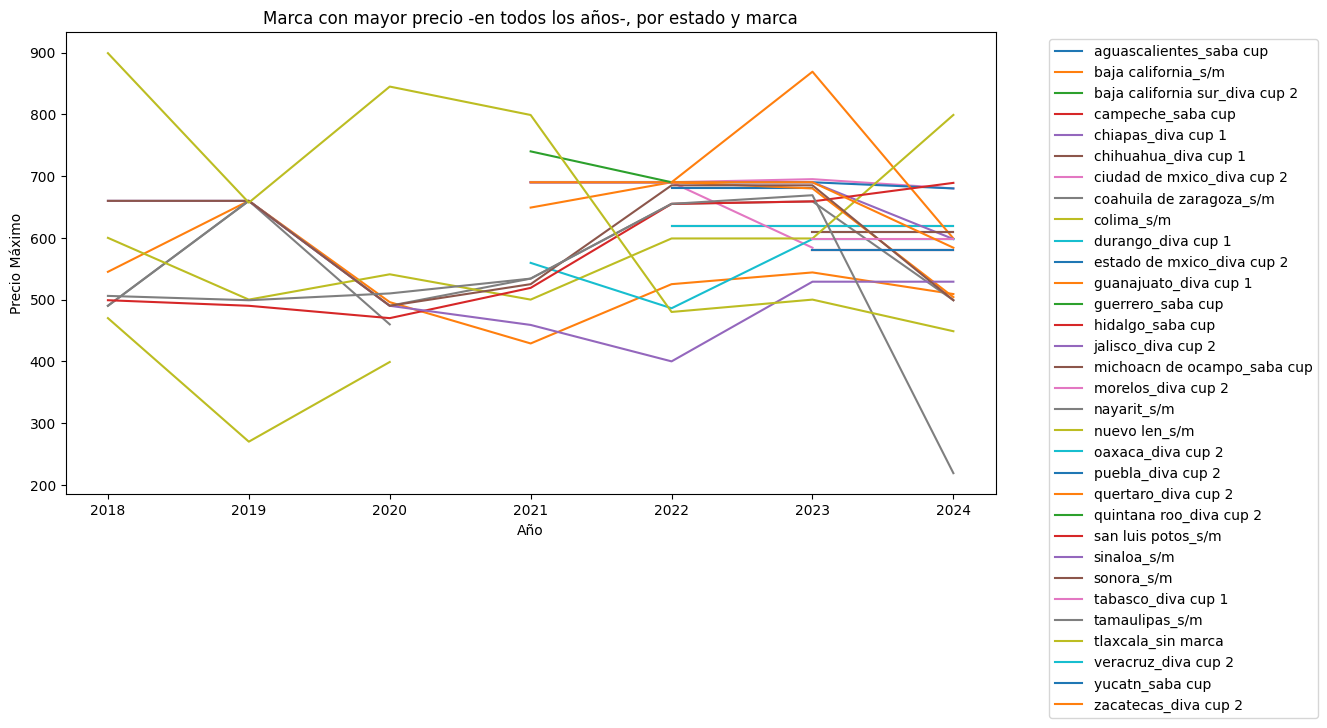

In [57]:
import seaborn as sns

tbl_serie_tiempo['estado_marca'] = tbl_serie_tiempo['estado'] + '_' + tbl_serie_tiempo['marca']
custom_palette = sns.color_palette("tab10", n_colors=len(tbl_serie_tiempo['estado'].unique()))
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=tbl_serie_tiempo, x='fecha_y', y='max_precio', hue='estado_marca', palette=custom_palette, ax=ax)

plt.title("Marca con mayor precio -en todos los años-, por estado y marca")
plt.ylabel('Precio Máximo')
plt.xlabel('Año')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Parte B

Base de datos profeco_db creada en Athena desde el servicio de Glue.

Crea una tabla externa profeco dentro de la base de datos profeco_db:

In [83]:
# Librerías
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Abrir un cliente de S3
import awswrangler as wr
import boto3
session = boto3.Session(profile_name='default')
s3 = session.client('s3')

In [12]:
query = '''
    CREATE EXTERNAL TABLE IF NOT EXISTS `profeco_db`.`profeco` (
    `producto` string,
    `presentacion` string,
    `marca` string,
    `categoria` string,
    `precio` double,
    `fecha_registro` date,
    `cadena_comercial` string,
    `giro` string,
    `nombre_comercial` string,
    `direccion` string,
    `estado` string,
    `municipio` string,
    `latitud` float,
    `longitud` float
    ) COMMENT "Tabla quien es quien, categoría básicos, 2018-2024."
    STORED AS PARQUET
    LOCATION 's3://proyecto-parcial-equipo-6/output/catalogo=basicos/'
    TBLPROPERTIES (
        'classification'='parquet',
        'skip.header.line.count'='1',
        'serialization.format'='1',
        'field.delim'='|'
    );
'''

In [13]:
wr.athena.read_sql_query(
    query, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

""


A partir de la siguiente pregunta utiliza Athena desde R o Python:

De acuerdo a la categoría que te haya tocado obtén (desde 2018 a 2022):

¿De qué año a qué año tienen datos de esa categoría?

In [14]:
query = '''
SELECT YEAR(fecha_registro) AS year
FROM profeco_db.profeco
GROUP BY YEAR(fecha_registro)
ORDER BY YEAR(fecha_registro) ASC;
'''

In [15]:
wr.athena.read_sql_query(
    query, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,year
0,2018
1,2019
2,2020
3,2021
4,2022
5,2023
6,2024


¿Cuántos registros de fecha hay vacíos?

In [20]:
query = '''
SELECT count(*) as fecha_vacia
FROM profeco_db.profeco
WHERE fecha_registro IS NULL
'''

In [21]:
wr.athena.read_sql_query(
    query, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,fecha_vacia
0,0


¿Cuántos registros tienes por año?

In [16]:
query = '''
SELECT YEAR(fecha_registro) AS year, count(*) as registros
FROM profeco_db.profeco
GROUP BY YEAR(fecha_registro)
ORDER BY YEAR(fecha_registro) ASC;
'''

In [17]:
wr.athena.read_sql_query(
    query, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,year,registros
0,2018,8804761
1,2019,7398860
2,2020,6170515
3,2021,6919490
4,2022,7945110
5,2023,7742108
6,2024,1986577


¿Cuál es el precio mínimo, máximo, promedio, desviación estándar, mediana,
cuantil 25 y 75% de tu categoría por año?

In [27]:
query = '''
SELECT 
    YEAR(fecha_registro) AS year,
    MIN(precio) AS precio_minimo,
    MAX(precio) AS precio_maximo,
    AVG(precio) AS precio_promedio,
    STDDEV(precio) AS desviacion_estandar,
    APPROX_PERCENTILE(precio, 0.5) AS mediana,
    APPROX_PERCENTILE(precio, 0.25) AS cuantil_25,
    APPROX_PERCENTILE(precio, 0.75) AS cuantil_75
FROM profeco_db.profeco
GROUP BY YEAR(fecha_registro)
ORDER BY YEAR(fecha_registro) ASC;
'''

In [28]:
wr.athena.read_sql_query(
    query, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,year,precio_minimo,precio_maximo,precio_promedio,desviacion_estandar,mediana,cuantil_25,cuantil_75
0,2018,1.0,899.0,46.443535,48.804696,29.907054,16.959644,54.795593
1,2019,1.0,659.9,47.617151,50.498669,30.426997,17.020141,56.213875
2,2020,1.0,844.9,51.223467,53.187706,32.879582,18.750451,61.333962
3,2021,1.0,798.9,53.788488,56.237459,34.266264,19.889285,64.614580
4,2022,1.0,690.0,59.716877,62.383836,38.648434,22.700432,71.222302
5,2023,1.2,869.0,65.701468,68.851441,42.236980,24.679558,79.291136
6,2024,1.3,799.0,66.911763,70.214783,42.887902,25.369582,80.865030


¿Cuáles son el top 5 de marcas con mayor precio en cada estado? ¿Verifica si te dió lo mismo en Spark?

In [60]:
query = '''
WITH ranked_brands AS (
    SELECT estado, marca, precio, ROW_NUMBER() OVER (PARTITION BY estado ORDER BY precio DESC) AS brand_rank
    FROM profeco_db.profeco
)
SELECT estado, marca, precio
FROM ranked_brands
WHERE brand_rank <= 5
ORDER BY estado ASC, brand_rank ASC;
'''

In [61]:
wr.athena.read_sql_query(
    query, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,estado,marca,precio
0,aguascalientes,saba cup,609.0
1,aguascalientes,saba cup,609.0
2,aguascalientes,saba cup,609.0
3,aguascalientes,saba cup,609.0
4,aguascalientes,saba cup,609.0
5,baja california,s/m,659.9
6,baja california,s/m,659.9
7,baja california,s/m,659.9
8,baja california,s/m,659.9
9,baja california,s/m,659.9


Sí da lo mismo que en Spark, salvo en el orden de algunas categorías cuyo mayor precio es el mismo.

¿Cuáles son el top 5 de marcas con menor precio en CDMX? (en aquel entonces Distrito Federal) ¿Verifica si te dió lo mismo en Spark?

In [62]:
query = '''
WITH ranked_brands AS (
    SELECT estado, marca, precio, ROW_NUMBER() OVER (PARTITION BY estado ORDER BY precio ASC) AS brand_rank
    FROM profeco_db.profeco
    WHERE estado = 'ciudad de mxico'
)
SELECT estado, marca, precio
FROM ranked_brands
WHERE brand_rank <= 5
ORDER BY estado ASC, brand_rank ASC;
'''

In [63]:
wr.athena.read_sql_query(
    query, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

,estado,marca,precio
0,ciudad de mxico,s/m,1.0
1,ciudad de mxico,s/m,1.0
2,ciudad de mxico,s/m,1.0
3,ciudad de mxico,s/m,1.1
4,ciudad de mxico,s/m,1.1


Sí da lo mismo que en Spark.

¿Cuáles son el top 5 de marcas con mayores observaciones? ¿Se parecen a las de nivel por estado? ¿Verifica si te dió lo mismo en Spark?

In [68]:
query = '''
WITH ranked_brands_t AS (
    SELECT marca, COUNT(*) AS observation_count, ROW_NUMBER() OVER (ORDER BY COUNT(*) DESC) AS brand_rank
    FROM profeco_db.profeco
    GROUP BY marca
)
SELECT marca, observation_count
FROM ranked_brands_t
WHERE brand_rank <= 5
ORDER BY observation_count DESC;
'''

In [71]:
top_brands_result = wr.athena.read_sql_query(
    query, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)

top_brands_result

,marca,observation_count
0,s/m,2762155
1,la costea,1311513
2,fud,1151111
3,bimbo,819541
4,lala,750189


Sí da exactamento lo mismo que en Spark.

Genera un boxplot por año, para cada una de las top 5 marcas de tu categoría.

In [91]:
# Creamos la lista de top5 marcas
top_brands_list = top_brands_result['marca'].tolist()
top_brands_list

['s/m', 'la costea', 'fud', 'bimbo', 'lala']

In [94]:
query = f'''
SELECT marca, precio, YEAR(fecha_registro) as year
FROM profeco_db.profeco
WHERE marca IN ({', '.join(["'" + brand + "'" for brand in top_brands_list])})
'''

In [95]:
# Obtenemos la data de las top 5 marcas
top5_brand_data = wr.athena.read_sql_query(
    query, 
    database="profeco_db", 
    ctas_approach=False, 
    boto3_session=session
)
top5_brand_data

,marca,precio,year
0,s/m,14.0,2019
1,s/m,16.0,2019
2,s/m,16.0,2019
3,s/m,15.0,2019
4,s/m,15.0,2019
...,...,...,...
6794504,bimbo,14.0,2019
6794505,bimbo,12.0,2019
6794506,s/m,12.0,2019
6794507,s/m,12.5,2019


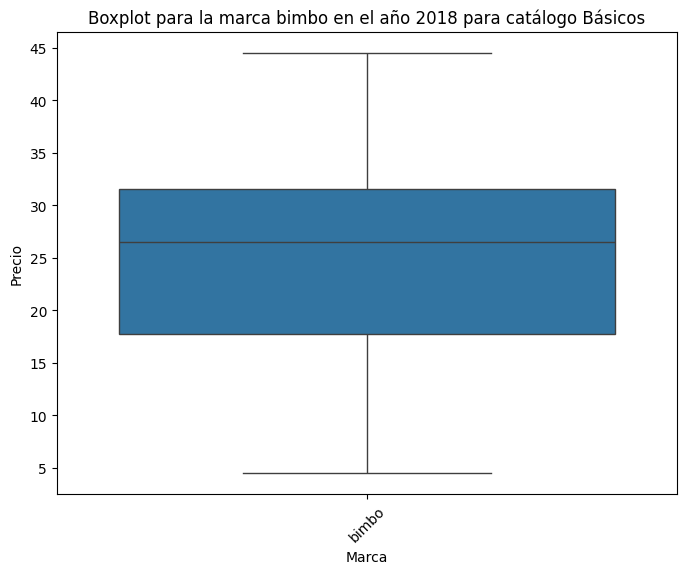

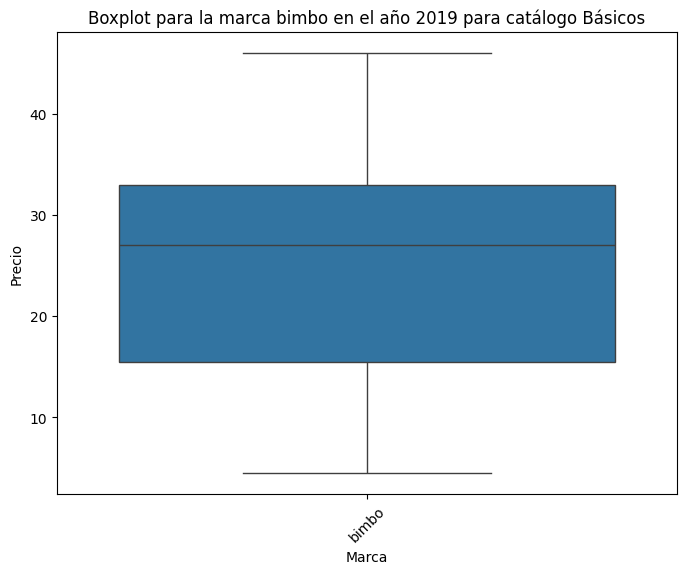

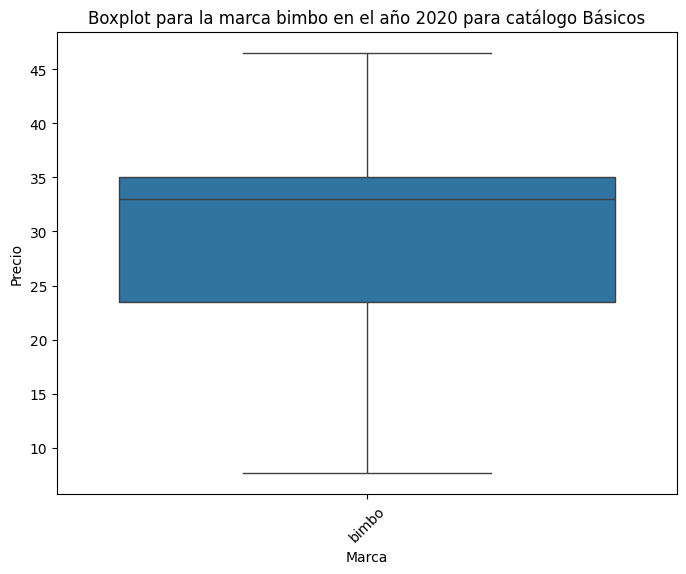

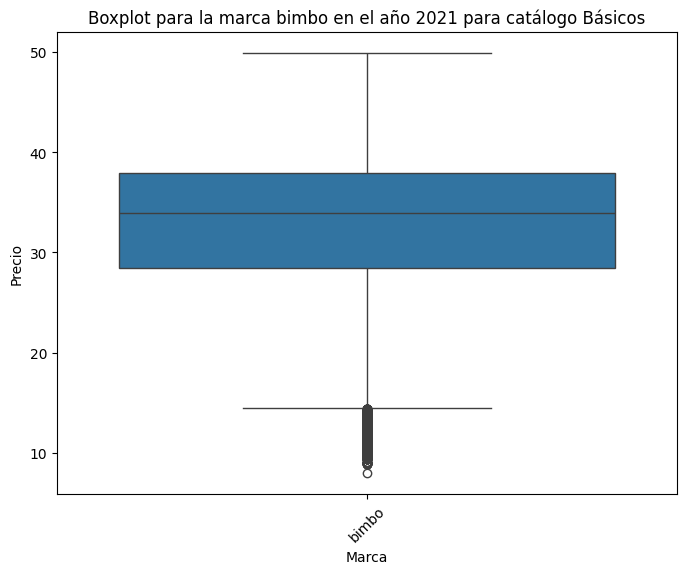

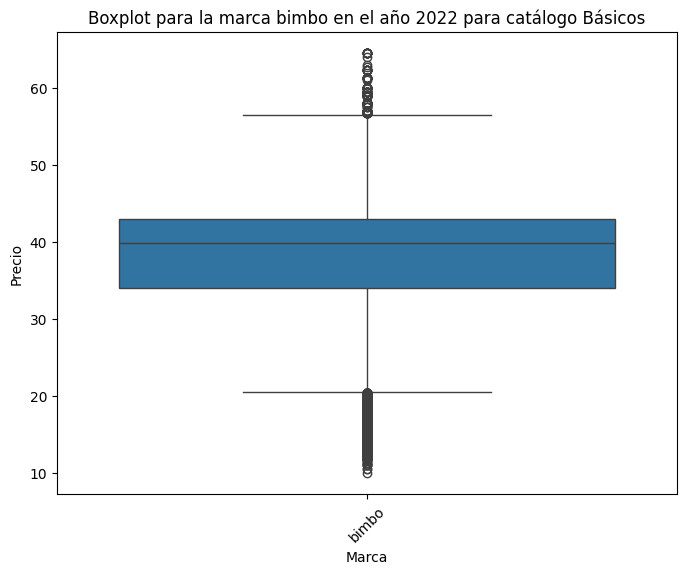

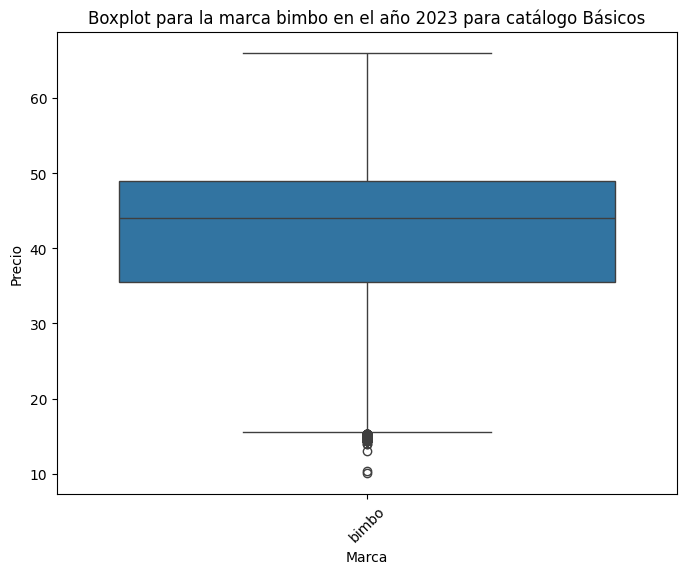

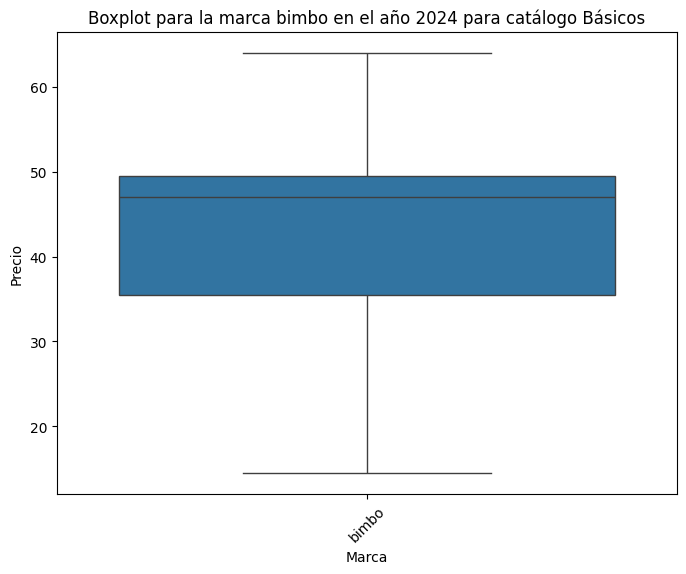

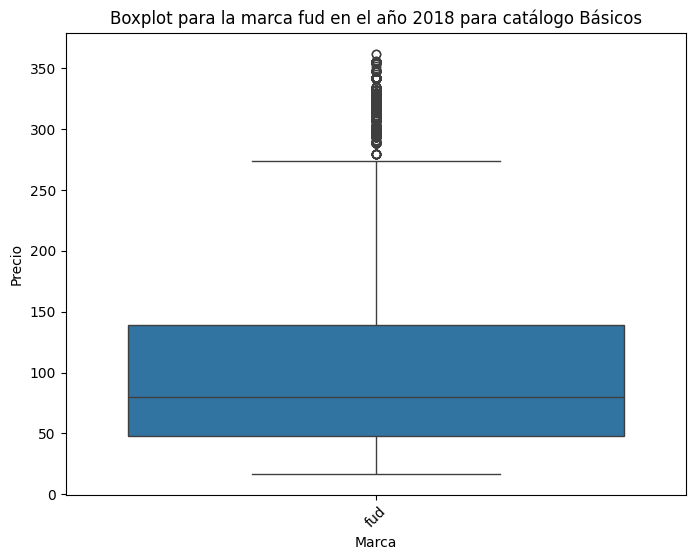

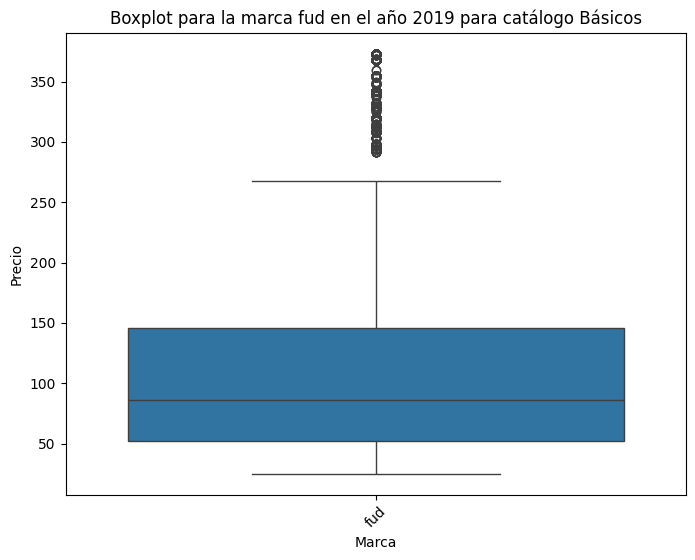

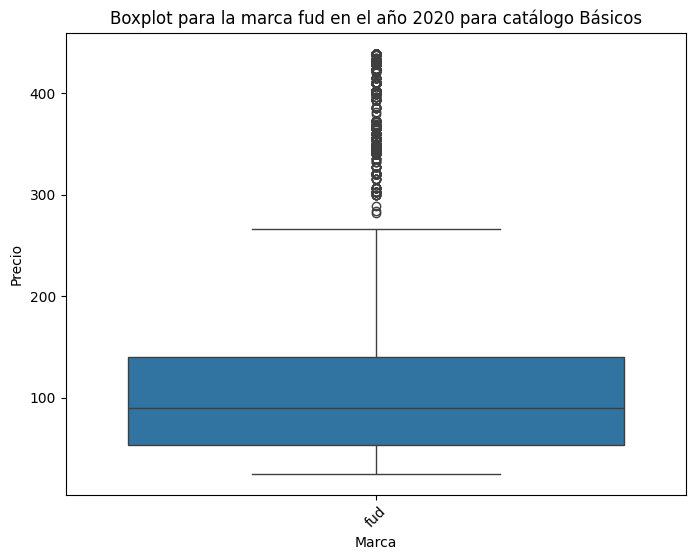

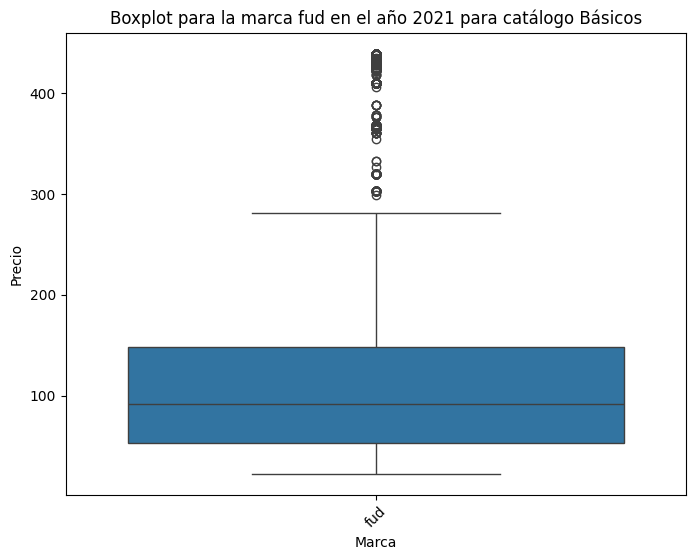

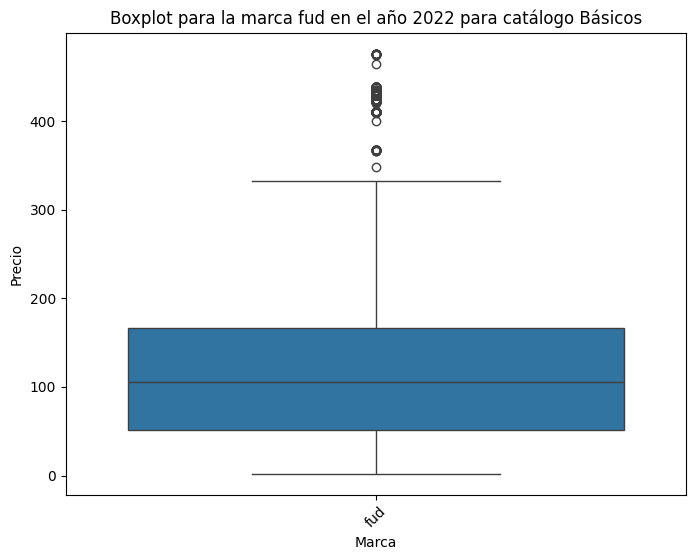

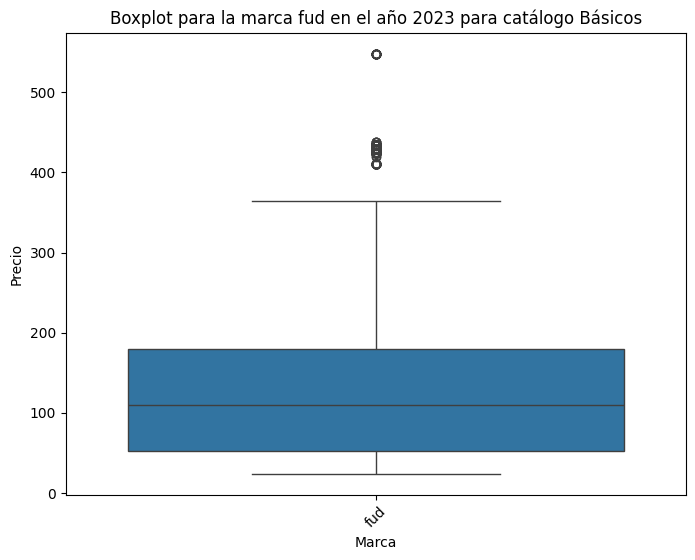

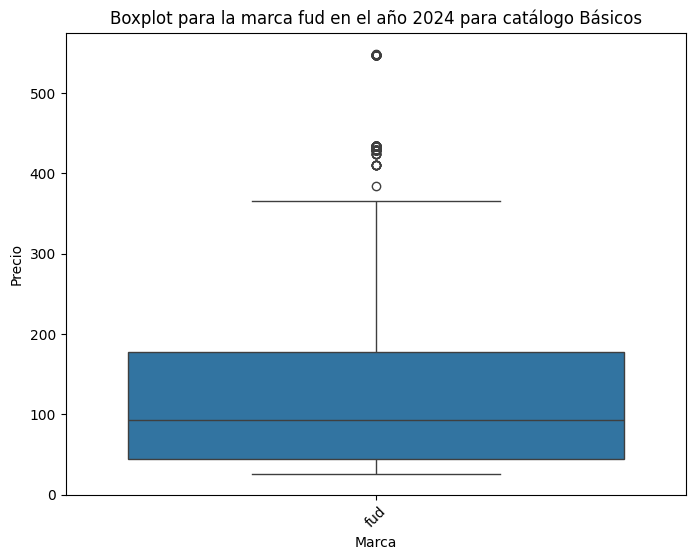

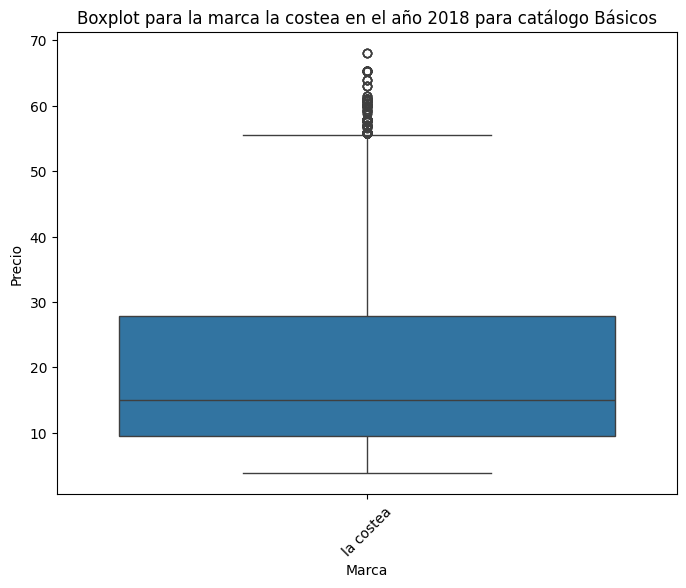

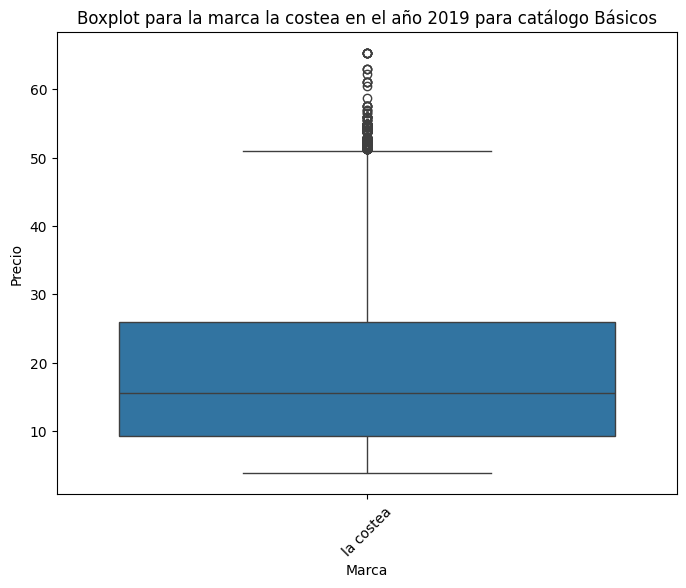

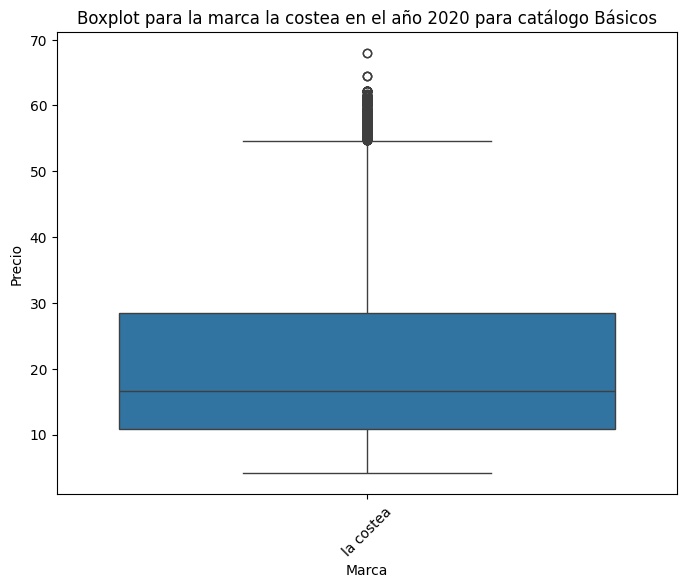

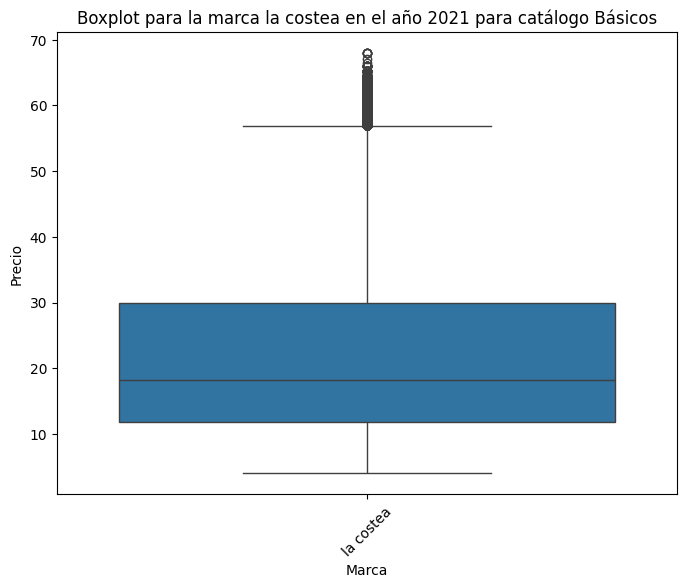

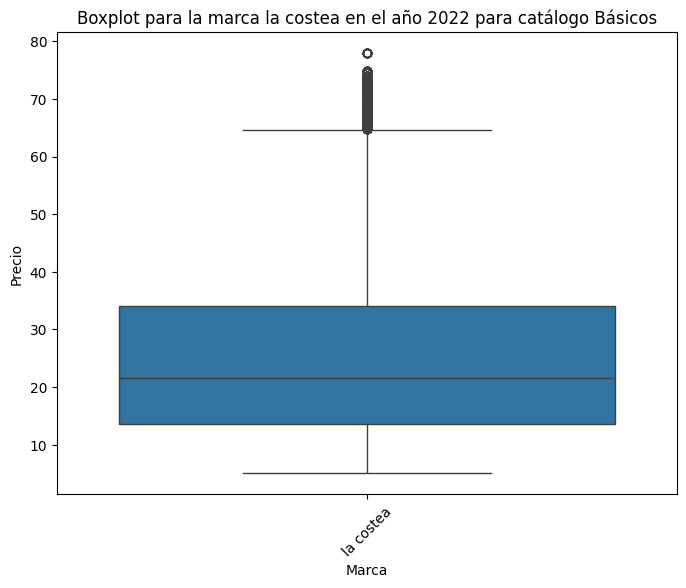

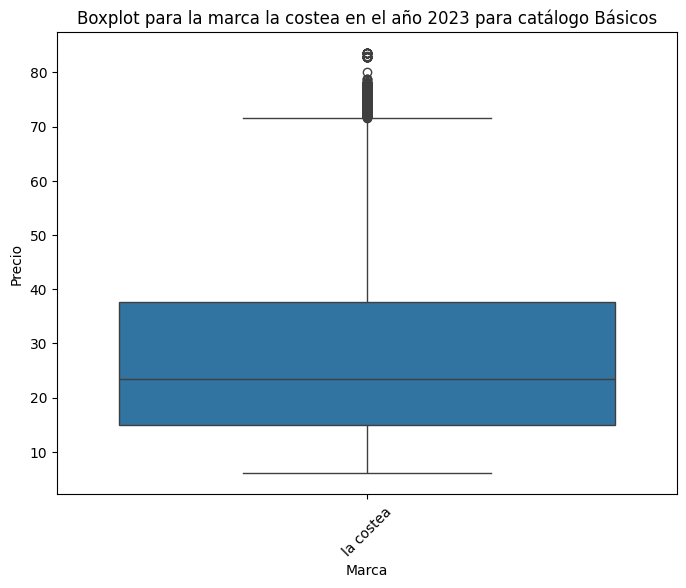

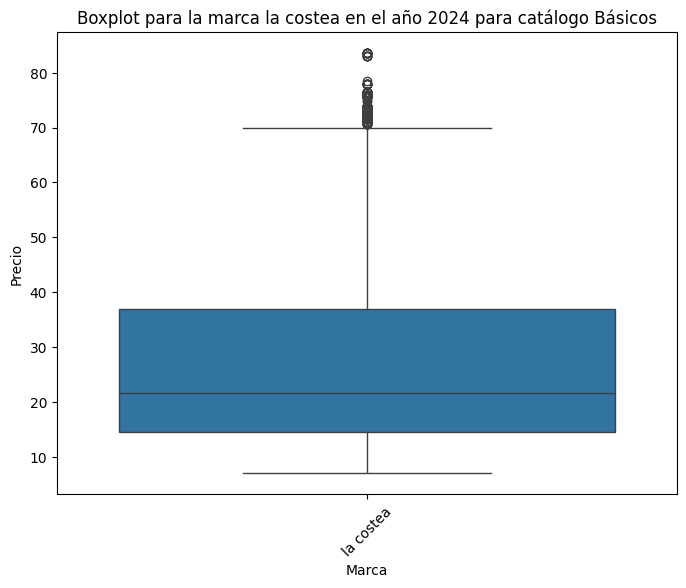

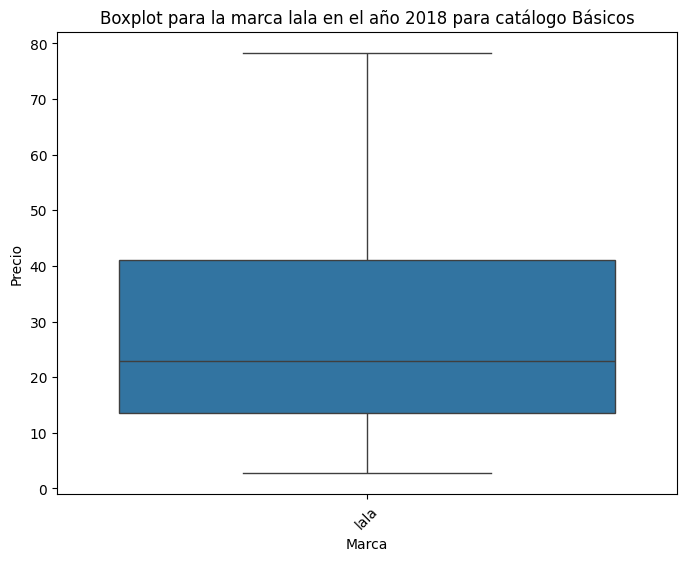

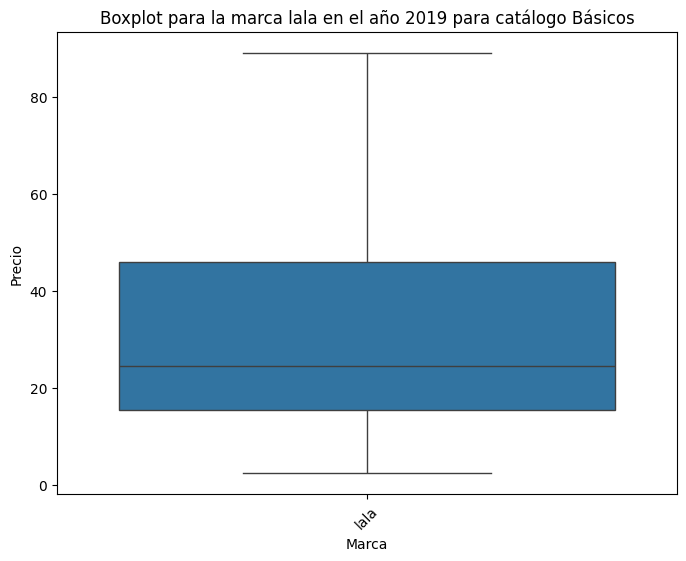

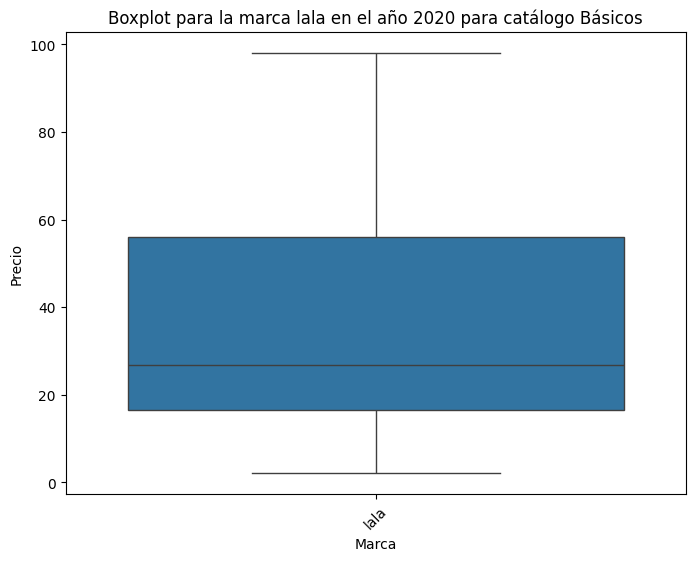

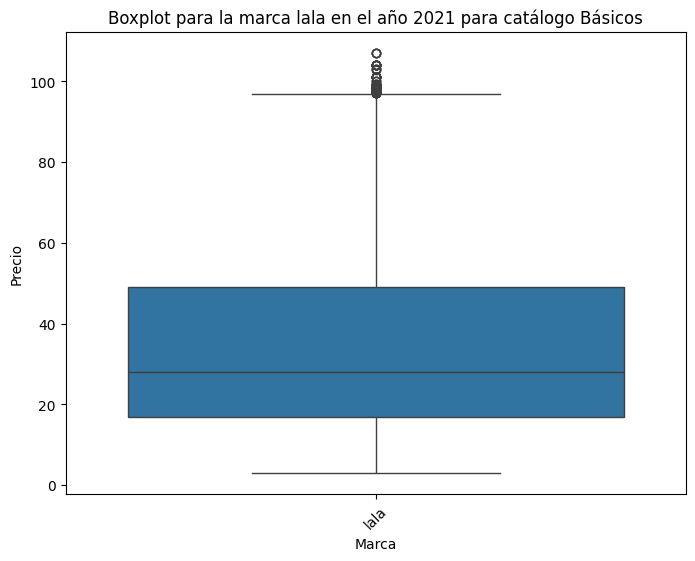

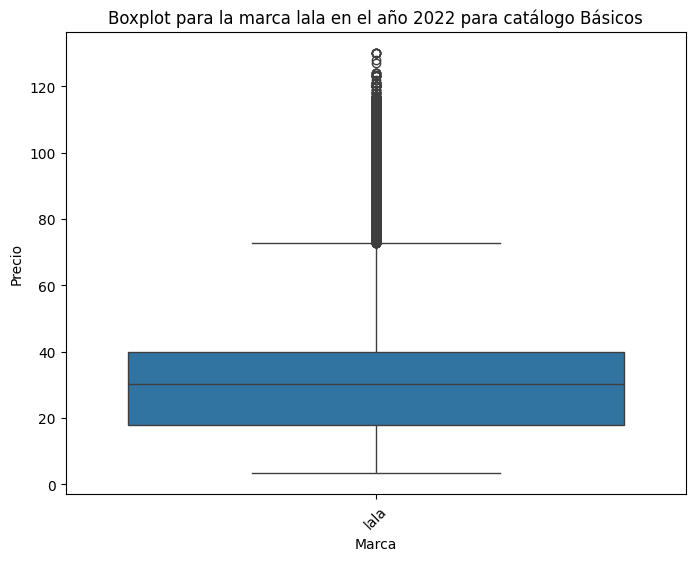

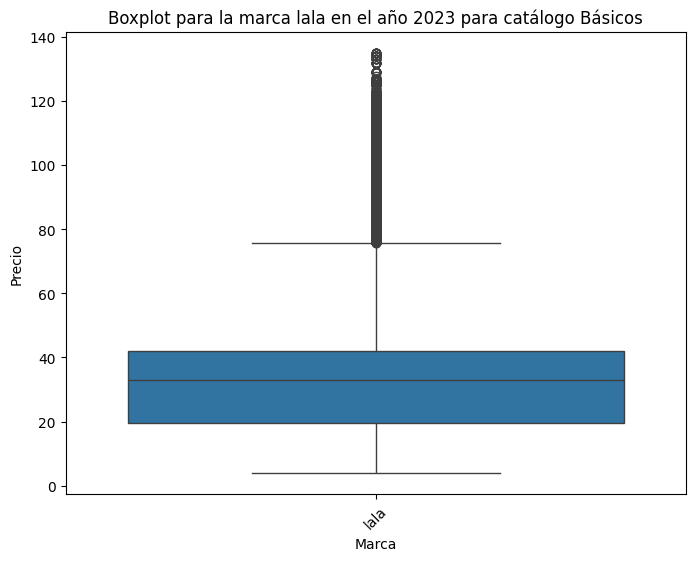

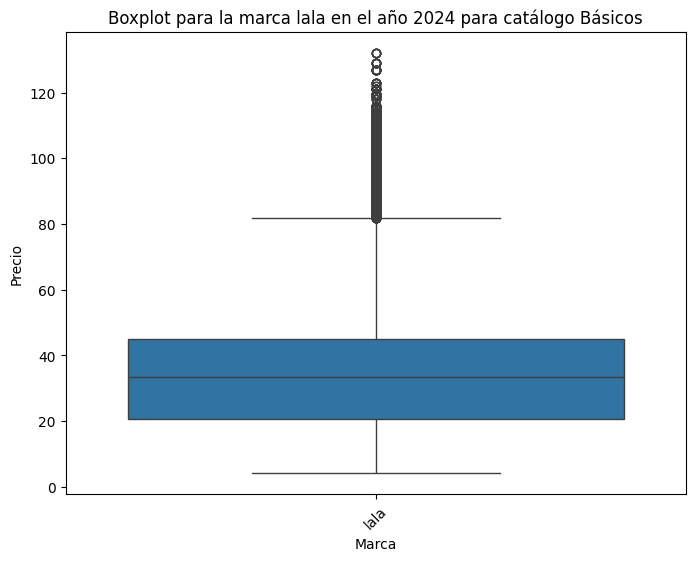

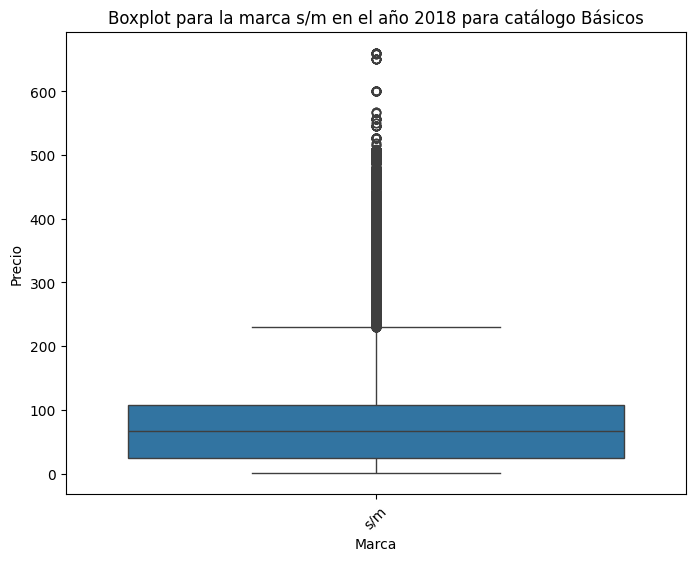

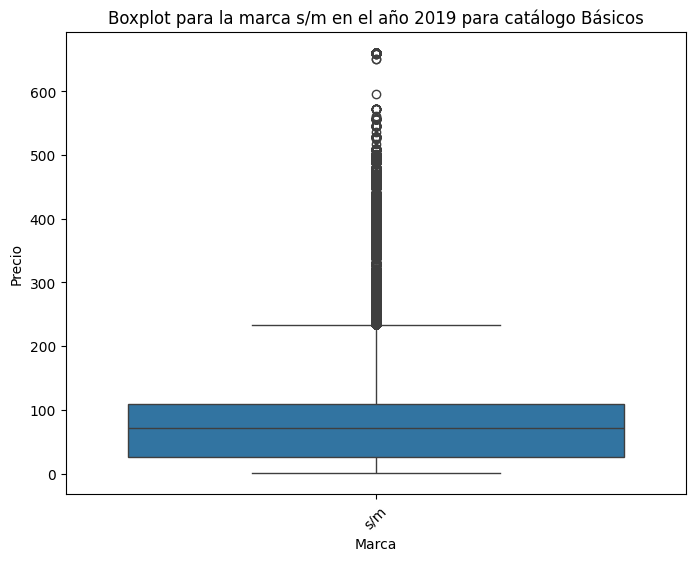

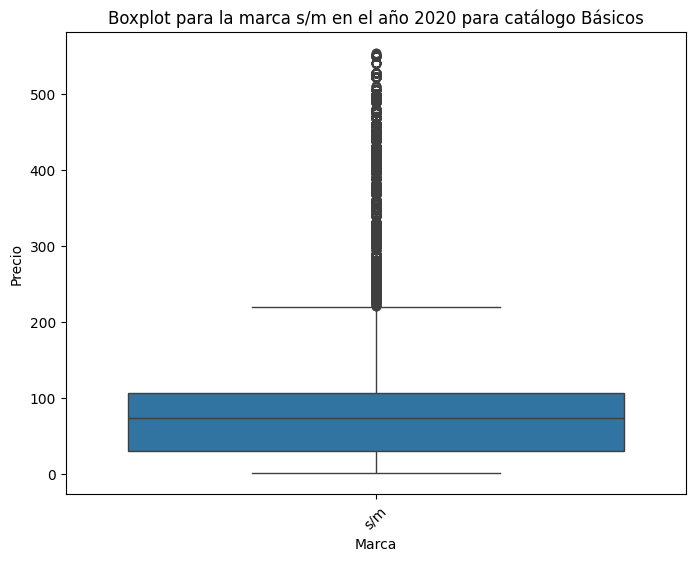

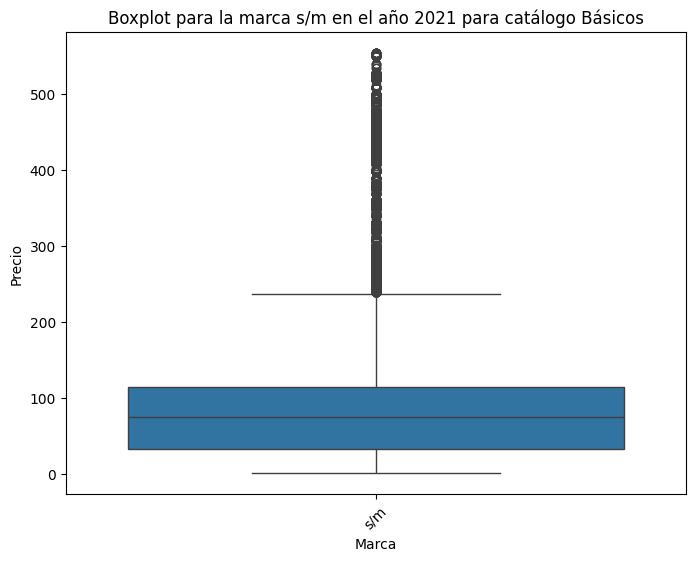

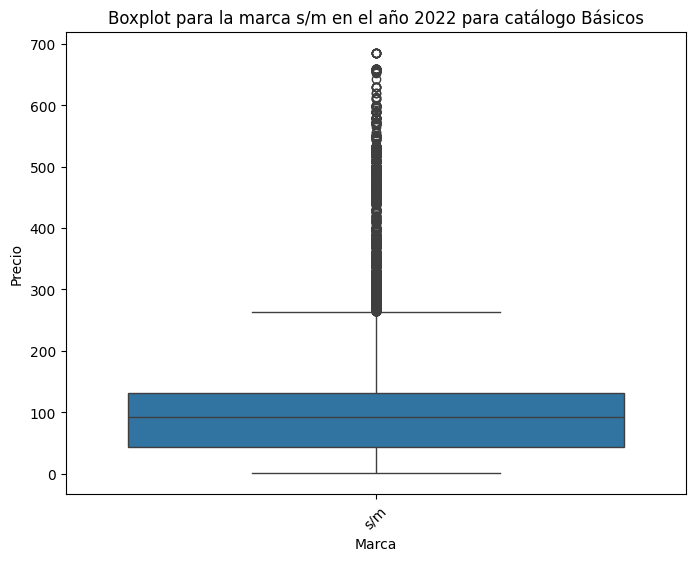

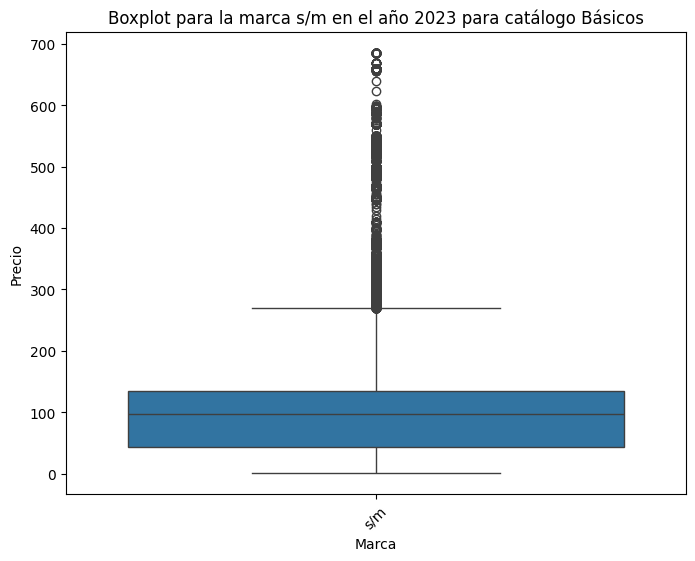

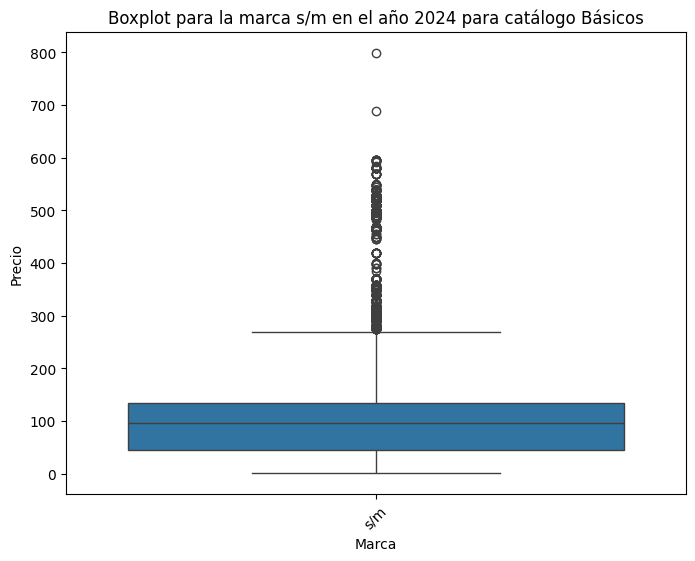

In [97]:
# Agrupamos data por marca y año
grouped_data = top5_brand_data.groupby(['marca', 'year'])

# Generar boxplots para cada año para cada top 5 marcas
for (marca, year), data in grouped_data:
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(data=data, x='marca', y='precio', ax=ax)
    ax.set_title(f'Boxplot para la marca {marca} en el año {year} para catálogo Básicos')
    ax.set_ylabel('Precio')
    ax.set_xlabel('Marca')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()